# Decision Tree Analysis on ACES Dataset
This notebook explores the ACES dataset using decision trees. We perform data loading, preprocessing, model training, and evaluation, with a focus on analyzing node accuracies and generating new samples to improve the model.

In [1]:
import scipy.io
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Data Loading and Basic Exploration
We begin by loading the dataset from `.mat` files and perform initial exploration to understand the structure and content of the data.

In [2]:
def load_mat_file(file_path):
    return scipy.io.loadmat(file_path)

base_path = '/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/ACES_dataset'
expression_data = load_mat_file(f'{base_path}/ACES_RefinedCommunity_AVG.mat')
label_data = load_mat_file(f'{base_path}/ACESLabel.mat')

expression_matrix = expression_data['data']
labels = label_data['label'].flatten()  

expression_df = pd.DataFrame(expression_matrix)
labels_df = pd.Series(labels, name='label')

### Basic Data Information
Display the number of samples and features in the dataset and examine the distribution of labels to understand the class balance.

In [3]:
def basic_data_info(expression_df, labels_df):
    print(f"Number of samples (rows): {expression_df.shape[0]}")
    print(f"Number of genes (columns): {expression_df.shape[1]}")
    print("\nLabels information:")
    print(labels_df.value_counts())

basic_data_info(expression_df, labels_df)

Number of samples (rows): 1616
Number of genes (columns): 37

Labels information:
label
0    1161
1     455
Name: count, dtype: int64


## Train-Test Split
Split the dataset into training and testing sets to evaluate model performance.

In [4]:
def split_data(expression_df, labels_df, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(expression_df, labels_df, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)

# Print sizes and class distributions
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)
print("\nTraining Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nTest Set Class Distribution:\n", y_test.value_counts(normalize=True))

Training Set Size: (1292, 37)
Test Set Size: (324, 37)

Training Set Class Distribution:
 label
0    0.724458
1    0.275542
Name: proportion, dtype: float64

Test Set Class Distribution:
 label
0    0.694444
1    0.305556
Name: proportion, dtype: float64


## Hyperparameter Tuning with Cross-Validation
We use a Decision Tree Classifier with grid search to find the best hyperparameters.

In [5]:
def perform_grid_search(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy'],
        # 'class_weight': [{0: 1, 1: 10}]
    }
    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, scoring='accuracy', verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Train the decision tree using GridSearch
grid_search = perform_grid_search(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


## Model Training

In this section, we train our decision tree model using the best hyperparameters found during hyperparameter tuning.

In [6]:
def train_best_model(grid_search, X_train, y_train):
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    return best_model

# Train the model using the best hyperparameters
best_model = train_best_model(grid_search, X_train, y_train)

## Initial Model Evaluation

After training the model, we evaluate its performance on the test set before adjusting the decision threshold. This provides a baseline for how well the model performs with the default threshold of 0.5.


Initial Model Evaluation:
Test Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       225
           1       0.58      0.07      0.13        99

    accuracy                           0.70       324
   macro avg       0.64      0.52      0.47       324
weighted avg       0.67      0.70      0.61       324



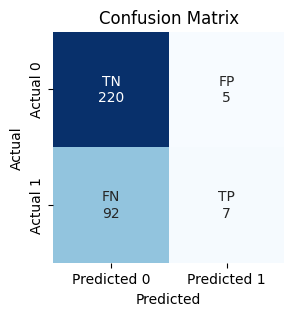

In [7]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    cm_with_labels = np.array([f"{label}\n{cm_val}" for label, cm_val in zip(labels.flatten(), cm.flatten())])
    cm_with_labels = cm_with_labels.reshape(2, 2)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=cm_with_labels, fmt="", cmap='Blues', cbar=False, square=True, 
                xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)

print("\nInitial Model Evaluation:")
evaluate_model(best_model, X_test, y_test)

## Adjusting Decision Threshold Using Cross-Validation

In this section, we adjust the decision threshold of our model using cross-validation to optimize the F1-score. This allows us to find a threshold that balances precision and recall without reducing the size of our training data.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve, f1_score

def cross_val_predict_proba(model, X, y, cv=5):
    """
    Performs cross-validated prediction of probabilities.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    y_proba = np.zeros(len(y))
    for train_index, val_index in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv = y.iloc[train_index]

        # Clone the existing model to avoid altering the original one
        model_clone = clone(model)
        model_clone.fit(X_train_cv, y_train_cv)

        # Predict probabilities on the validation fold
        y_proba[val_index] = model_clone.predict_proba(X_val_cv)[:, 1]
    return y_proba

# Use the best estimator from grid search
best_model = grid_search.best_estimator_

# Get cross-validated predicted probabilities
y_train_proba = cross_val_predict_proba(best_model, X_train, y_train, cv=5)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Avoid division by zero
f1_scores = np.nan_to_num(f1_scores)

# Find the threshold that maximizes F1-score
optimal_idx = np.argmax(f1_scores)
best_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold from Cross-Validation: {best_threshold:.2f}")

Optimal Threshold from Cross-Validation: 0.29


## Model Evaluation After Adjusting Threshold

In this section, we evaluate the model's performance on the test set using the adjusted decision threshold. This allows us to compare the model's performance before and after threshold adjustment.


Model Evaluation After Adjusting Threshold:
Test Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       225
           1       0.45      0.55      0.49        99

    accuracy                           0.66       324
   macro avg       0.61      0.63      0.62       324
weighted avg       0.68      0.66      0.67       324



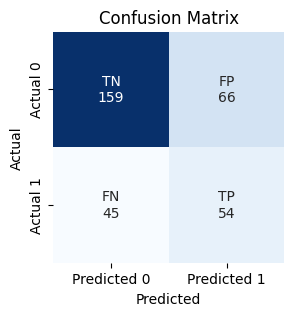

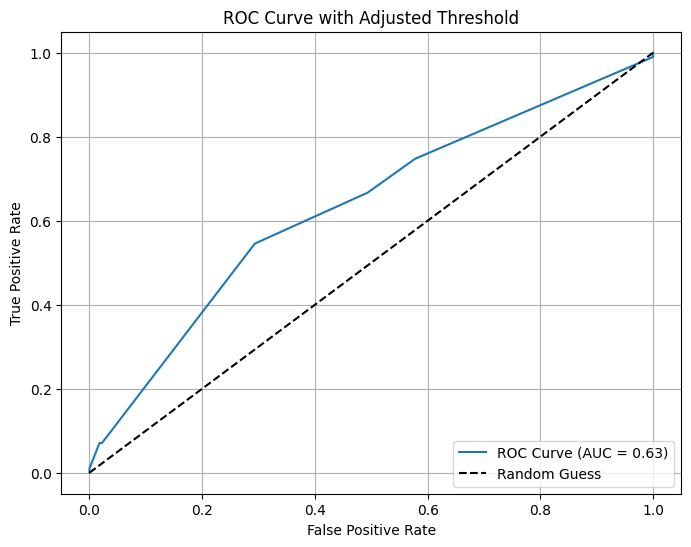

In [9]:
def evaluate_model_with_threshold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

# Get predicted probabilities on the test set using the existing model
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("\nModel Evaluation After Adjusting Threshold:")
evaluate_model_with_threshold(y_test, y_test_pred)


from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve using the predicted probabilities
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

# Find the index of the threshold closest to the adjusted threshold
optimal_idx = np.argmin(np.abs(roc_thresholds - best_threshold))
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Mark the point corresponding to the adjusted threshold
# plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, label=f'Adjusted Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Adjusted Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Manually Adjusting Decision Threshold

In this section, we explore different approaches to adjust the decision threshold for our model. Adjusting the threshold is crucial, especially when dealing with imbalanced datasets or when specific performance metrics (such as precision, recall, or F1-score) need to be prioritized. Below, we examine several strategies to fine-tune the threshold beyond the default value of 0.5.


### 1. Manually Adjusting the Decision Threshold across a range (0.1 to 0.9)

This section provides a approach to evaluate model performance across a range of decision thresholds.

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

def plot_performance_metrics(results):
    # Plotting Accuracy, Precision, Recall, and F1-Score for both classes
    plt.figure(figsize=(12, 8))

    # Plot for class 1
    plt.plot(results['Threshold'], results['Precision_1 (Class 1)'], marker='o', linestyle='-', color='blue', label='Precision (Class 1)')
    plt.plot(results['Threshold'], results['Recall_1 (Class 1)'], marker='o', linestyle='-', color='red', label='Recall (Class 1)')
    plt.plot(results['Threshold'], results['F1-Score_1 (Class 1)'], marker='o', linestyle='-', color='green', label='F1-Score (Class 1)')

    # Plot for class 0
    plt.plot(results['Threshold'], results['Precision_0 (Class 0)'], marker='x', linestyle='--', color='cyan', label='Precision (Class 0)')
    plt.plot(results['Threshold'], results['Recall_0 (Class 0)'], marker='x', linestyle='--', color='magenta', label='Recall (Class 0)')
    plt.plot(results['Threshold'], results['F1-Score_0 (Class 0)'], marker='x', linestyle='--', color='yellow', label='F1-Score (Class 0)')

    # Plot for Accuracy
    plt.plot(results['Threshold'], results['Accuracy'], marker='s', linestyle='-.', color='black', label='Accuracy')

    plt.title('Model Performance Evaluation Across Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def evaluate_thresholds(model, X_test, y_test, thresholds):
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Initialize lists to store evaluation metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Additional lists for class-specific metrics
    precision_0 = []
    recall_0 = []
    f1_0 = []

    precision_1 = []
    recall_1 = []
    f1_1 = []

    # Evaluate each threshold
    for threshold in thresholds:
        # Apply the custom threshold to determine predicted class labels
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        
        # Calculate confusion matrix to derive class-specific metrics
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, false negatives, true positives
        
        # Corrected Metrics for class 0 (negative class)
        precision_0_value = tn / (tn + fn) if (tn + fn) > 0 else 0
        recall_0_value = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_0_value = 2 * precision_0_value * recall_0_value / (precision_0_value + recall_0_value) if (precision_0_value + recall_0_value) > 0 else 0
        
        # Metrics for class 1 (positive class)
        precision_1_value = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_1_value = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_1_value = 2 * precision_1_value * recall_1_value / (precision_1_value + recall_1_value) if (precision_1_value + recall_1_value) > 0 else 0
        
        # Append metrics to lists
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        precision_0.append(precision_0_value)
        recall_0.append(recall_0_value)
        f1_0.append(f1_0_value)
        precision_1.append(precision_1_value)
        recall_1.append(recall_1_value)
        f1_1.append(f1_1_value)
    
    # Create a DataFrame to store results
    results = pd.DataFrame({
        'Threshold': thresholds,
        'Accuracy': accuracies,
        'Precision_1 (Class 1)': precision_1,  # Should use precision_1 instead of precisions
        'Recall_1 (Class 1)': recall_1,        # Should use recall_1 instead of recalls
        'F1-Score_1 (Class 1)': f1_1,          # Should use f1_1 instead of f1_scores
        'Precision_0 (Class 0)': precision_0,  # Correctly using precision_0
        'Recall_0 (Class 0)': recall_0,        # Correctly using recall_0
        'F1-Score_0 (Class 0)': f1_0,          # Correctly using f1_0
    })

    return results

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)


results = evaluate_thresholds(best_model, X_test, y_test, thresholds)
display(results)
plot_performance_metrics(results)

### 2. Adjusting Threshold Using Class Proportions

This approach sets the threshold based on the proportion of each class in the training set. For instance, if the positive class is underrepresented, the threshold can be lowered to increase sensitivity to the positive class.

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

def adjust_threshold_using_class_proportions(model, X_test, y_test, y_train):
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate the class proportions from the training set
    class_proportion = y_train.value_counts(normalize=True)
    positive_proportion = class_proportion[1]
    negative_proportion = class_proportion[0]

    # Set the threshold based on the class proportions
    threshold = positive_proportion / (positive_proportion + negative_proportion)
    print(f"Calculated Threshold from Class Proportions: {threshold:.2f}")

    # Apply the custom threshold to determine predicted class labels
    y_pred_custom = (y_proba >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    cm = confusion_matrix(y_test, y_pred_custom)
    report = classification_report(y_test, y_pred_custom)

    # Output evaluation metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)


adjust_threshold_using_class_proportions(best_model, X_test, y_test, y_train)

### 3. Adjusting Decision Threshold Using Cross-Validation

In this section, we adjust the decision threshold of our existing trained model using cross-validation to optimize the F1-score. This approach helps us find the threshold that provides the best balance between precision and recall for our classification task.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.base import clone

def cross_val_predict_proba(model, X, y, cv=5):
    """
    Performs cross-validated prediction of probabilities.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    y_proba = np.zeros(len(y))
    for train_index, val_index in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv = y.iloc[train_index]

        # Clone the existing model to avoid altering the original one
        model_clone = clone(model)
        model_clone.fit(X_train_cv, y_train_cv)

        # Predict probabilities on the validation fold
        y_proba[val_index] = model_clone.predict_proba(X_val_cv)[:, 1]
    return y_proba

# Use your existing trained model
best_model = grid_search.best_estimator_

# Get cross-validated predicted probabilities
y_train_proba = cross_val_predict_proba(best_model, X_train, y_train, cv=5)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Avoid division by zero
f1_scores = np.nan_to_num(f1_scores)

# Find the threshold that maximizes F1-score
optimal_idx = np.argmax(f1_scores)
best_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold from Cross-Validation: {best_threshold:.2f}")

# Get predicted probabilities on the test set using the existing model
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

def evaluate_model_with_threshold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

# Evaluate the model on the test set
print("\nEvaluation of the Model on the Test Set with Adjusted Threshold:")
evaluate_model_with_threshold(y_test, y_test_pred)

## Node Accuracy Calculation
Calculate the accuracy of each node in the decision tree to identify how well the model performs within each node.

In [10]:
# Function to calculate node accuracy
def calculate_node_accuracy(tree_model, X_train, y_train):
    leaf_ids = tree_model.apply(X_train)
    node_accuracies = {}
    for node_id in np.unique(leaf_ids):
        sample_ids = np.where(leaf_ids == node_id)[0]
        y_true = y_train.iloc[sample_ids]  
        y_pred = tree_model.predict(X_train.iloc[sample_ids]) 
        correct_predictions = np.sum(y_true == y_pred)
        total_samples = len(sample_ids)
        accuracy = correct_predictions / total_samples if total_samples > 0 else 0
        node_accuracies[node_id] = accuracy
    return node_accuracies

# Calculate node accuracy
node_accuracies = calculate_node_accuracy(best_model, X_train, y_train)

## Decision Tree Visualization for Traning Set

Visualize the tree with node IDs and accuracies to better understand model decisions.


Initial Decision Tree Visualization with Node Accuracy:


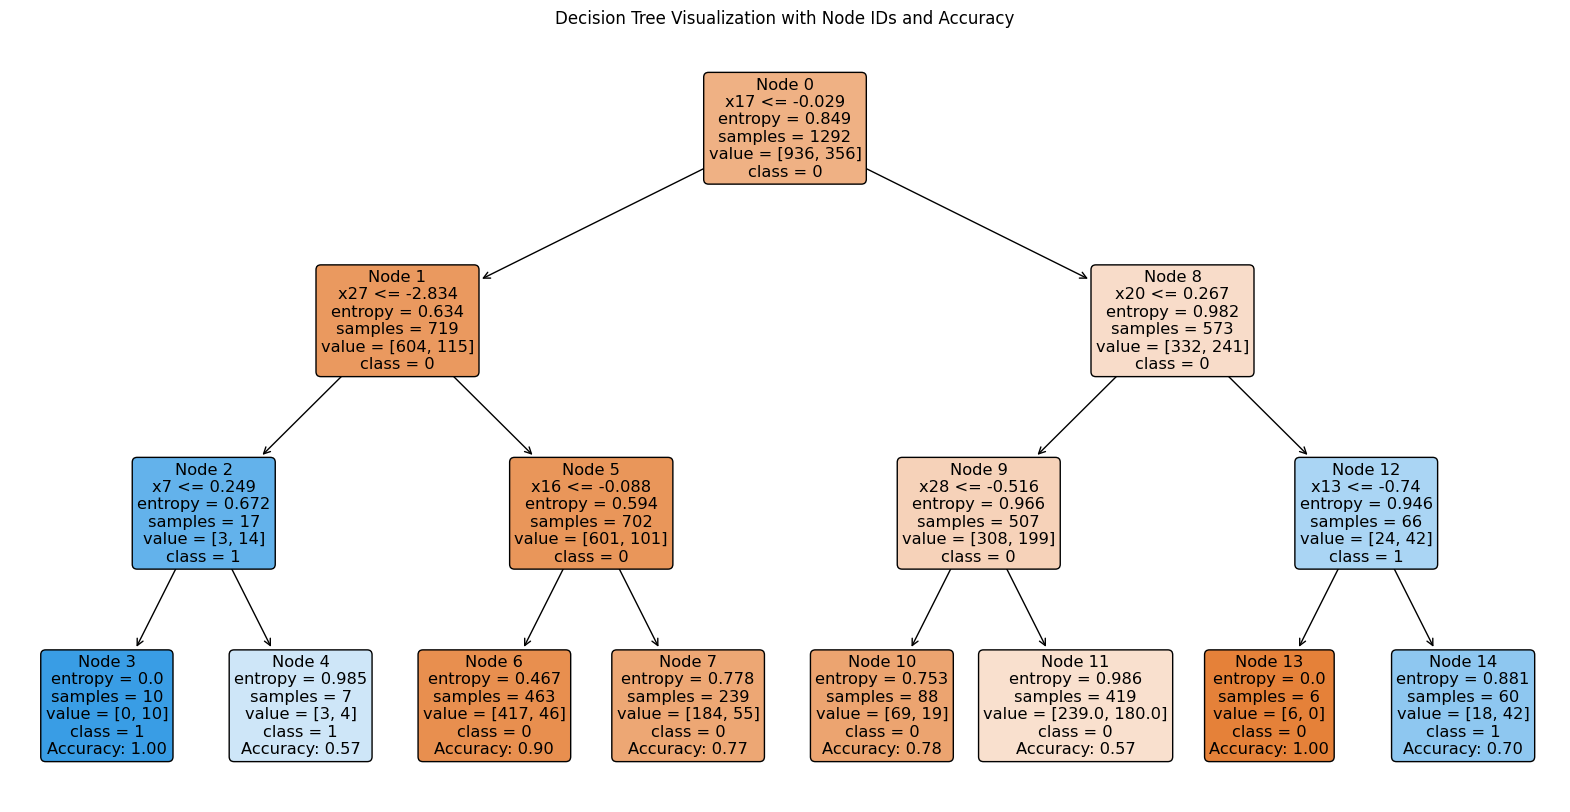

In [11]:
def visualize_tree_with_node_accuracy(tree_model, node_accuracies, feature_names):
    plt.figure(figsize=(20, 10))
    tree_plot = tree.plot_tree(tree_model, filled=True, feature_names=feature_names, class_names=["0", "1"], rounded=True)
    ax = plt.gca()
    for idx, text in enumerate(ax.texts):
        node_id = idx
        text.set_text(f"Node {node_id}\n" + text.get_text())
        if node_id in node_accuracies:
            node_accuracy = node_accuracies[node_id]
            updated_text = text.get_text() + f"\nAccuracy: {node_accuracy:.2f}"
            text.set_text(updated_text)
    plt.title("Decision Tree Visualization with Node IDs and Accuracy")
    plt.show()

print("\nInitial Decision Tree Visualization with Node Accuracy:")
num_features = X_train.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
visualize_tree_with_node_accuracy(best_model, node_accuracies, feature_names)

## Decision Tree Visualization for Test Set

In this section, we visualize the decision tree with the test set data to observe how well the model performs on unseen data.

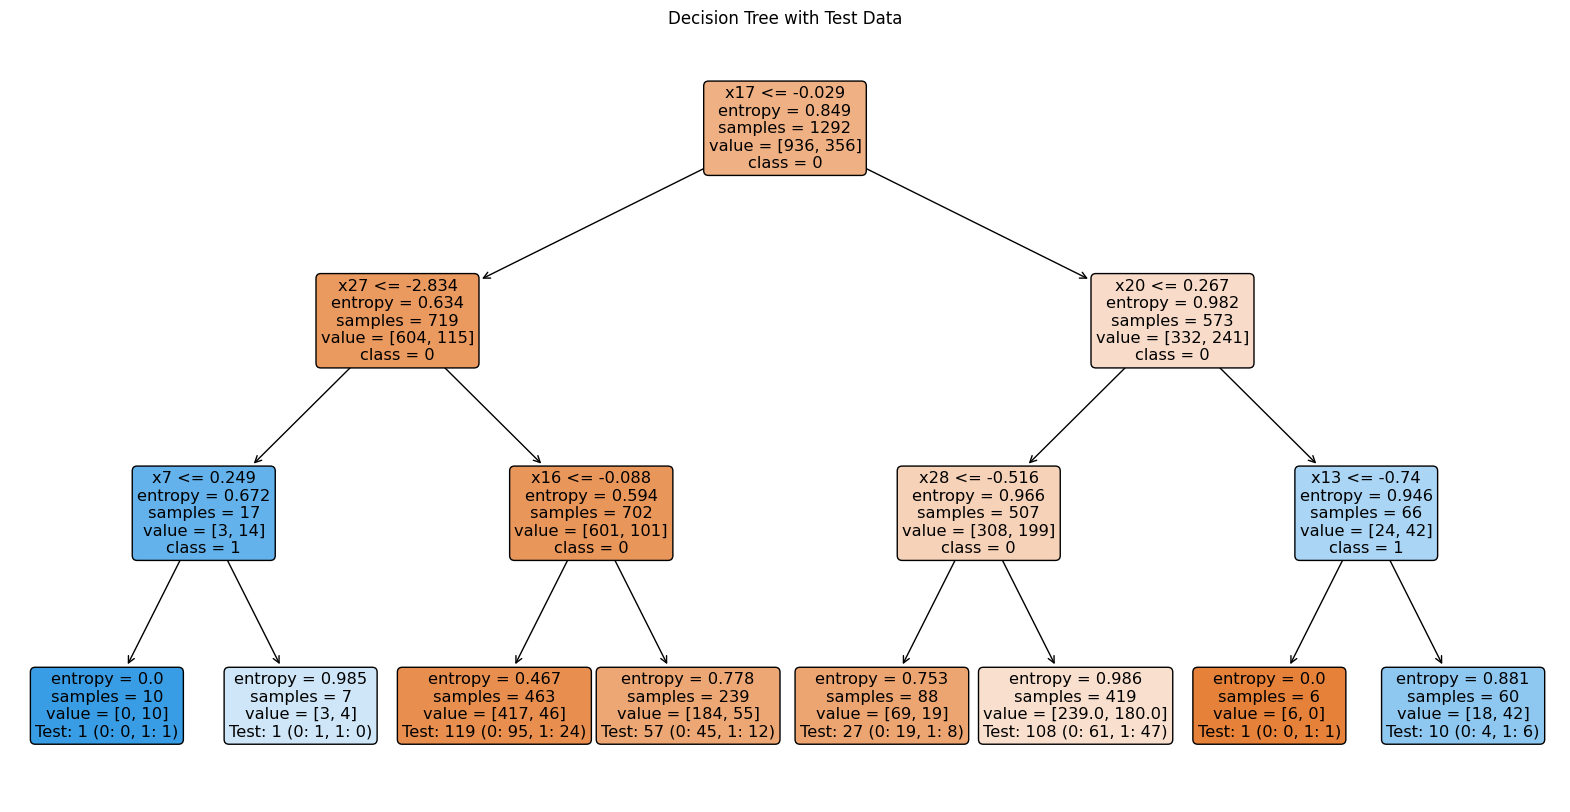

In [12]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def annotate_tree_with_test_data(tree_model, X_test, y_test, feature_names):
    # Apply the model to get the leaf nodes for each test instance
    leaf_ids = tree_model.apply(X_test)

    # Count the number of occurrences of each class in each leaf node
    leaf_counts = {}
    for leaf_id, label in zip(leaf_ids, y_test):
        if leaf_id not in leaf_counts:
            leaf_counts[leaf_id] = {'total': 0, 'class_0': 0, 'class_1': 0}
        leaf_counts[leaf_id]['total'] += 1
        if label == 0:
            leaf_counts[leaf_id]['class_0'] += 1
        else:
            leaf_counts[leaf_id]['class_1'] += 1

    # Visualize the tree
    plt.figure(figsize=(20, 10))
    tree_plot = plot_tree(tree_model, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True)

    # Modify annotations to include test data information
    for i, text in enumerate(plt.gca().texts):
        # Node id is assumed to be the i-th node
        if i in leaf_counts:
            text_parts = text.get_text().split('\n')
            text_parts[-1] = f"Test: {leaf_counts[i]['total']} (0: {leaf_counts[i]['class_0']}, 1: {leaf_counts[i]['class_1']})"
            text.set_text('\n'.join(text_parts))

    plt.title("Decision Tree with Test Data")
    plt.show()

# Assuming 'best_model' is your trained DecisionTreeClassifier
num_features = X_test.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
annotate_tree_with_test_data(best_model, X_test, y_test, feature_names)

## Feature Range Calculation for Nodes

To improve model's performance, we analyze the range of specific features for class 1 samples in selected nodes. This helps us understand feature distributions that could affect model performance.

Currently, we focus on node 14 and node 6. Our goal is to generate augmented data for node 14, using features that define the path to this node (x17, x20, x13). 

To make the new samples more effective, we calculate the ranges of these features and avoid overlapping with node 6’s feature ranges. Node 6’s accuracy for class 0 is nearly 90%, indicating a strong confidence in class 0 predictions. By avoiding these feature ranges, we aim to create robust samples that enhance overall model performance.

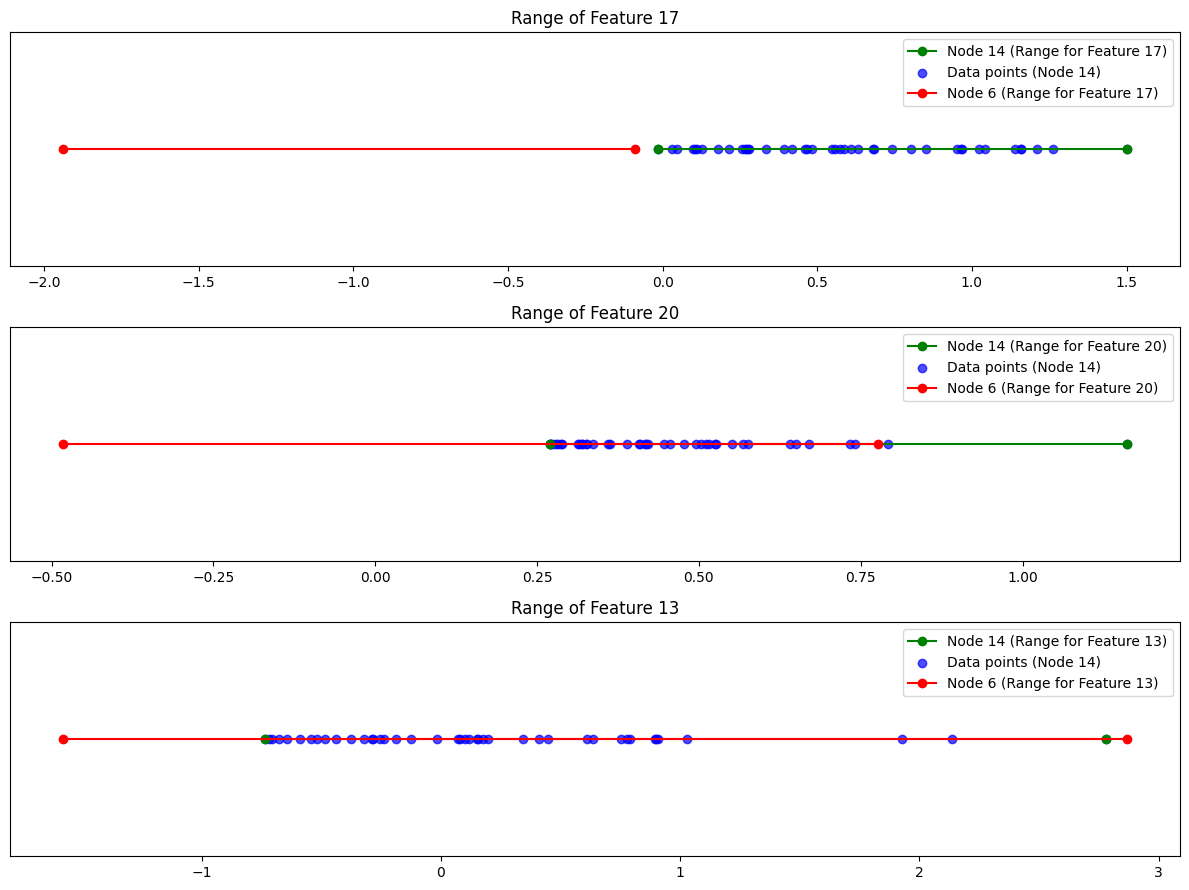

In [13]:
import matplotlib.pyplot as plt

def calculate_feature_ranges(tree_model, X_train, y_train, target_node_id, avoid_node_id, features):
    ranges = {}
    node_samples = {}
    
    for node_id in [target_node_id, avoid_node_id]:
        leaf_ids = tree_model.apply(X_train)  # Get the leaf node assignments for each sample
        samples_in_node = X_train.iloc[leaf_ids == node_id]  # Get samples for the current node
        class_1_samples = samples_in_node[y_train.iloc[leaf_ids == node_id] == 1]  # Filter class 1 samples
        
        # Initialize an empty dict to store ranges for the current node
        ranges[node_id] = {}
        
        # Iterate over the features to calculate ranges
        for feature in features:
            # Get the min and max values for the current feature
            min_value = class_1_samples.iloc[:, feature].min()
            max_value = class_1_samples.iloc[:, feature].max()
            
            # Store the range for the current node and feature
            ranges[node_id][feature] = (min_value, max_value)
            
            # # Print the data points that are creating the range
            # min_point = class_1_samples[class_1_samples.iloc[:, feature] == min_value]
            # max_point = class_1_samples[class_1_samples.iloc[:, feature] == max_value]
            
            # print(f"\nNode {node_id}, Feature {feature}:")
            # print(f"Min value: {min_value}, corresponding data point(s):{min_point[[feature]]}")
            # print(f"Max value: {max_value}, corresponding data point(s):{max_point[[feature]]}")
        
        # Store the class 1 samples for future use
        node_samples[node_id] = class_1_samples
    
    return ranges, node_samples

def plot_feature_ranges(ranges, features, node_samples, target_node_id, range_colors=["green", "red"], point_color="blue"):
    fig, axs = plt.subplots(len(features), 1, figsize=(12, len(features) * 3))
    
    for i, feature in enumerate(features):
        for j, (node_id, node_ranges) in enumerate(ranges.items()):
            feature_range = node_ranges[feature]
            # Plot the feature range for each node
            axs[i].plot(feature_range, [i]*2, marker='o', color=range_colors[j], label=f"Node {node_id} (Range for Feature {feature})")
            axs[i].set_title(f"Range of Feature {feature}")
            
            # Only plot the actual data points for the target node
            if node_id == target_node_id:
                data_points = node_samples[node_id].iloc[:, feature]  # Extract the data points for this feature
                axs[i].scatter(data_points, [i]*len(data_points), color=point_color, alpha=0.7, label=f"Data points (Node {node_id})")
    
    for ax in axs:
        ax.legend()
        ax.set_yticks([]) 

    plt.tight_layout()
    plt.show()

# Define everything outside the functions
target_node_id = 14  # Node ID for the target node
avoid_node_id = 6   # Node ID for the node to avoid
features_of_interest = [17, 20, 13]  # List of feature indices to calculate ranges for

# Calculate the feature ranges and get the data points for each node
ranges, node_samples = calculate_feature_ranges(best_model, X_train, y_train, target_node_id, avoid_node_id, features_of_interest)

# Plot feature ranges along with data points only for the target node
plot_feature_ranges(ranges, features_of_interest, node_samples, target_node_id)

## Generating New Samples
Generate new samples that avoid specific feature ranges identified in a previous analysis.

We are generating same amount of class 1 samples in node 14.

In [14]:
import numpy as np
import pandas as pd

# Function to determine if we can avoid the range
def can_avoid_range(valid_range, avoid_range):
    return not (valid_range[0] >= avoid_range[0] and valid_range[1] <= avoid_range[1])

# Function to sample within a range while avoiding a specific range
def sample_avoiding_range(valid_range, avoid_range):
    while True:
        value = np.random.uniform(valid_range[0], valid_range[1])
        if not (avoid_range[0] <= value <= avoid_range[1]):
            return value

# Function to identify features with valid ranges
def identify_valid_ranges(target_ranges, avoid_ranges):
    valid_features = {}
    for feature, valid_range in target_ranges.items():
        avoid_range = avoid_ranges.get(feature, None)
        
        if avoid_range is not None:
            # Check if the feature has a valid range
            if can_avoid_range(valid_range, avoid_range):
                valid_features[feature] = valid_range
            else:
                print(f"Skipping feature {feature} as no valid range is available.")
        else:
            # No avoid range is available; this feature is valid
            valid_features[feature] = valid_range
            print(f"No avoid_range available for feature {feature}.")

    return valid_features

# Function to generate samples using valid ranges from the target node
def generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples):
    np.random.seed(42)
    generated_samples = []
    
    for _ in range(num_samples):
        sample = {}
        
        # Generate new samples based on valid ranges
        for feature, valid_range in valid_ranges.items():
            avoid_range = avoid_ranges.get(feature, None)
            
            # Attempt to generate a sample for this feature
            if avoid_range is not None:
                sample_value = sample_avoiding_range(valid_range, avoid_range)
            else:
                # If no avoid range, just sample within the valid range
                sample_value = np.random.uniform(valid_range[0], valid_range[1])
            
            sample[feature] = sample_value
        
        # Fill in the rest of the features, excluding those in valid_ranges
        features_to_drop = list(valid_ranges.keys())
        other_features = target_data.drop(columns=features_to_drop).sample(n=1, replace=True).iloc[0].to_dict()
        sample.update(other_features)
        
        generated_samples.append(sample)
    
    # Convert the list of samples into a DataFrame
    generated_samples_df = pd.DataFrame(generated_samples)
    
    # Ensure the column order matches the original data
    desired_order = target_data.columns.tolist()
    generated_samples_df = generated_samples_df[desired_order]
    generated_samples_df['label'] = 1  # Assign label 1 for class 1 samples

    return generated_samples_df

# Define parameters outside the functions
target_data = X_train[(best_model.apply(X_train) == target_node_id) & (y_train == 1)]  # Extract data for the target node

# Get the feature ranges for the target and avoid nodes
target_ranges = ranges.get(target_node_id, {})
avoid_ranges = ranges.get(avoid_node_id, {})

# Identify features with valid ranges for the target node, avoiding ranges from the avoid node
valid_ranges = identify_valid_ranges(target_ranges, avoid_ranges)

# Number of samples to generate (same as the number of class 1 samples in the target node)
num_class_1_samples_target = len(target_data)

# Generate samples using valid ranges
generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples=35)

print(f"\nNumber of generated samples: {len(generated_samples)}")

# Displaying the generated samples to confirm correctness
# print("\nGenerated Samples:")
# print(generated_samples)

Skipping feature 13 as no valid range is available.

Number of generated samples: 35


## Passing Generated Samples through the Decision Tree

In this section, we will evaluate how the newly generated samples (from node 14) pass through the original decision tree (best_model). We will treat the generated samples as a test set, pass them through the decision tree, and visualize which leaf nodes they land in.

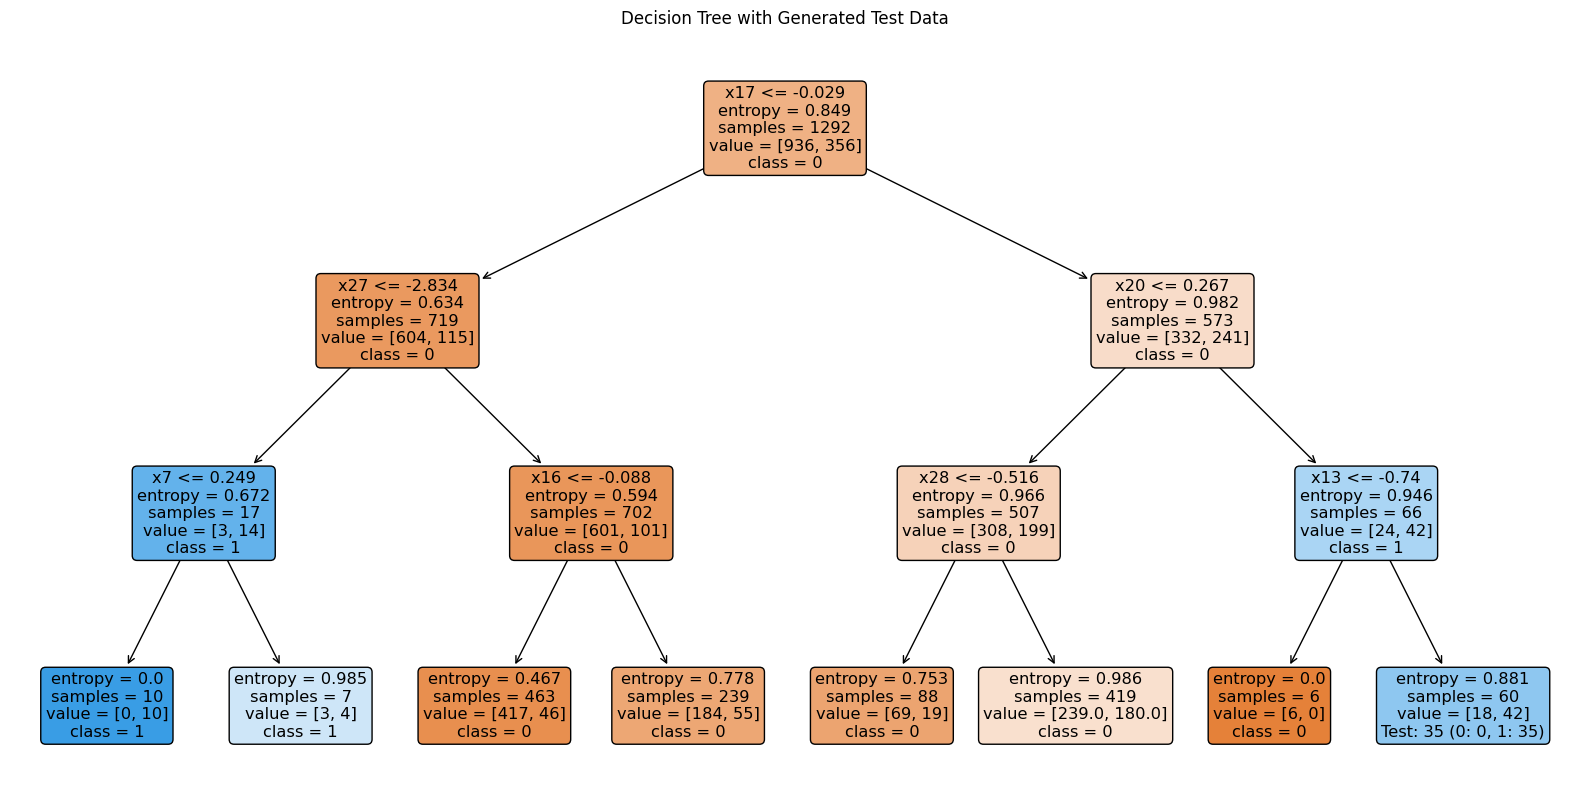

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Function to annotate and visualize decision tree with test data
def annotate_tree_with_test_data(tree_model, X_test, y_test, feature_names):
    # Apply the model to get the leaf nodes for each test instance
    leaf_ids = tree_model.apply(X_test)

    # Count the number of occurrences of each class in each leaf node
    leaf_counts = {}
    for leaf_id, label in zip(leaf_ids, y_test):
        if leaf_id not in leaf_counts:
            leaf_counts[leaf_id] = {'total': 0, 'class_0': 0, 'class_1': 0}
        leaf_counts[leaf_id]['total'] += 1
        if label == 0:
            leaf_counts[leaf_id]['class_0'] += 1
        else:
            leaf_counts[leaf_id]['class_1'] += 1

    # Visualize the tree
    plt.figure(figsize=(20, 10))
    tree_plot = plot_tree(tree_model, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True)

    # Modify annotations to include test data information
    for i, text in enumerate(plt.gca().texts):
        # Node id is assumed to be the i-th node
        if i in leaf_counts:
            text_parts = text.get_text().split('\n')
            text_parts[-1] = f"Test: {leaf_counts[i]['total']} (0: {leaf_counts[i]['class_0']}, 1: {leaf_counts[i]['class_1']})"
            text.set_text('\n'.join(text_parts))

    plt.title("Decision Tree with Generated Test Data")
    plt.show()

# Extract feature columns and labels from the generated samples
X_generated_test = generated_samples.drop(columns=['label'])
y_generated_test = generated_samples['label']

# Use the original trained tree model (best_model) and pass the generated samples as the test set
num_features = X_generated_test.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]  # Adjust feature names if needed

# Annotate the tree using generated samples as test data
annotate_tree_with_test_data(best_model, X_generated_test, y_generated_test, feature_names)

## Merging New Samples with the Training Set

In this section, we will merge the newly generated samples with the existing training set.

In [16]:
## Merging New Samples with the Original Training Set

# Concatenate the new generated samples with the original training set
X_train_augmented = pd.concat([X_train, generated_samples.drop(columns=['label'])], ignore_index=True)
y_train_augmented = pd.concat([y_train, generated_samples['label']], ignore_index=True)

# Display the new size of the training set
print(f"\nTraining data size after adding new samples: {X_train_augmented.shape}")
print(f"Label size after adding new samples: {y_train_augmented.shape}")

# Check the distribution of the labels in the augmented training set
print("\nLabel distribution in the augmented training set:")
print(y_train_augmented.value_counts(normalize=True))


Training data size after adding new samples: (1327, 37)
Label size after adding new samples: (1327,)

Label distribution in the augmented training set:
label
0    0.70535
1    0.29465
Name: proportion, dtype: float64


## Performance Comparison of Initial and Augmented Decision Tree Models
In this section, we start by visualizing the initial decision tree with node accuracy annotations. We then augment the training data with newly generated samples and retrain the decision tree using the best hyperparameters obtained from grid search. 

Finally, we visualize the retrained tree and evaluate its performance on the test set to observe any improvements.

### Section 1: Plot the Initial Decision Tree and Augmented Decision Tree


Initial Decision Tree Visualization with Node Accuracy:


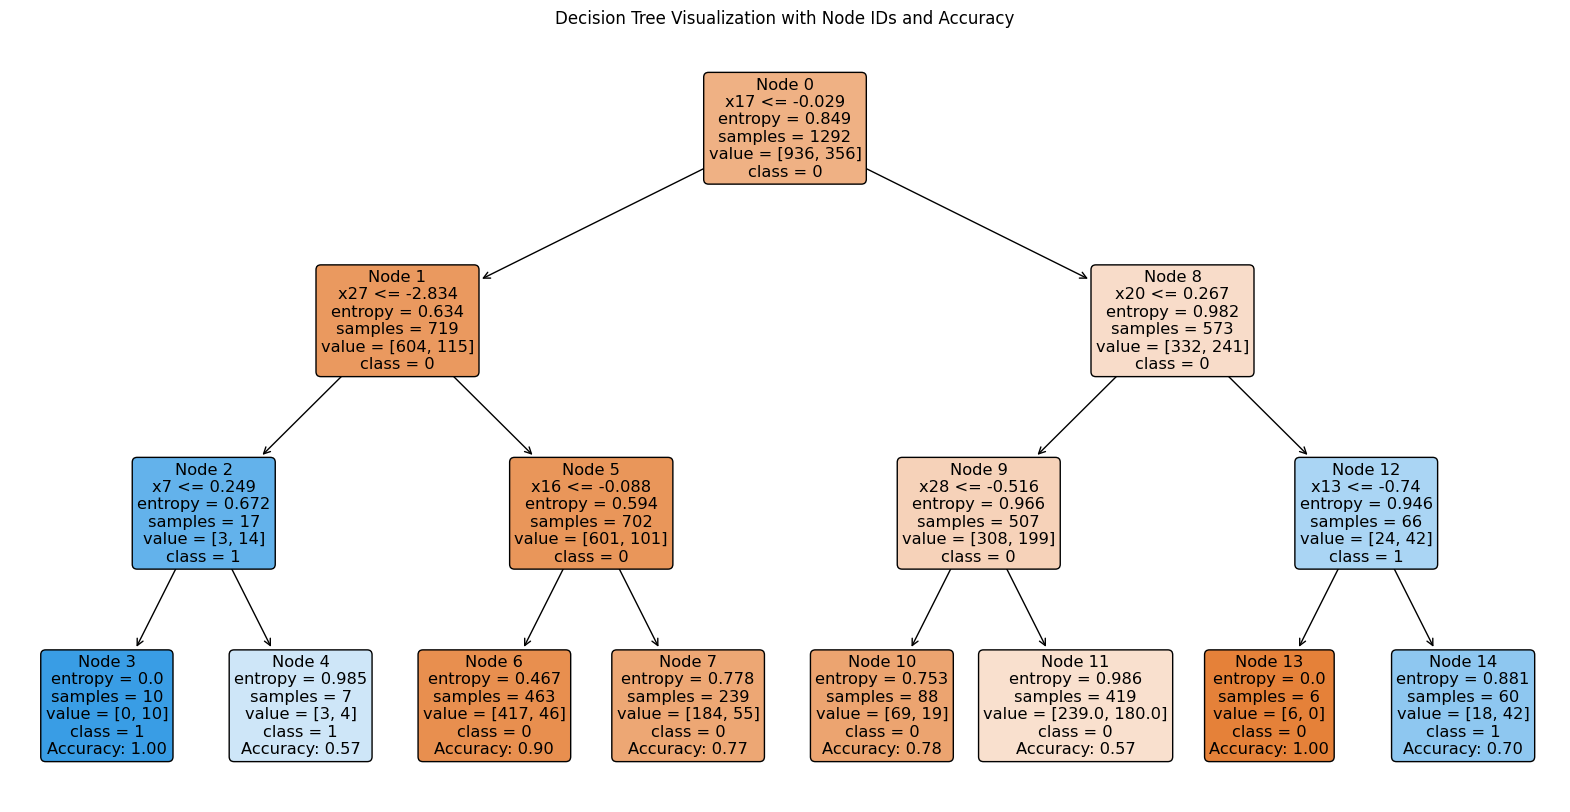


Merging New Samples with the Original Training Set:
Best Parameters for Retrained Model: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Visualization of Retrained Decision Tree with Node Accuracy:


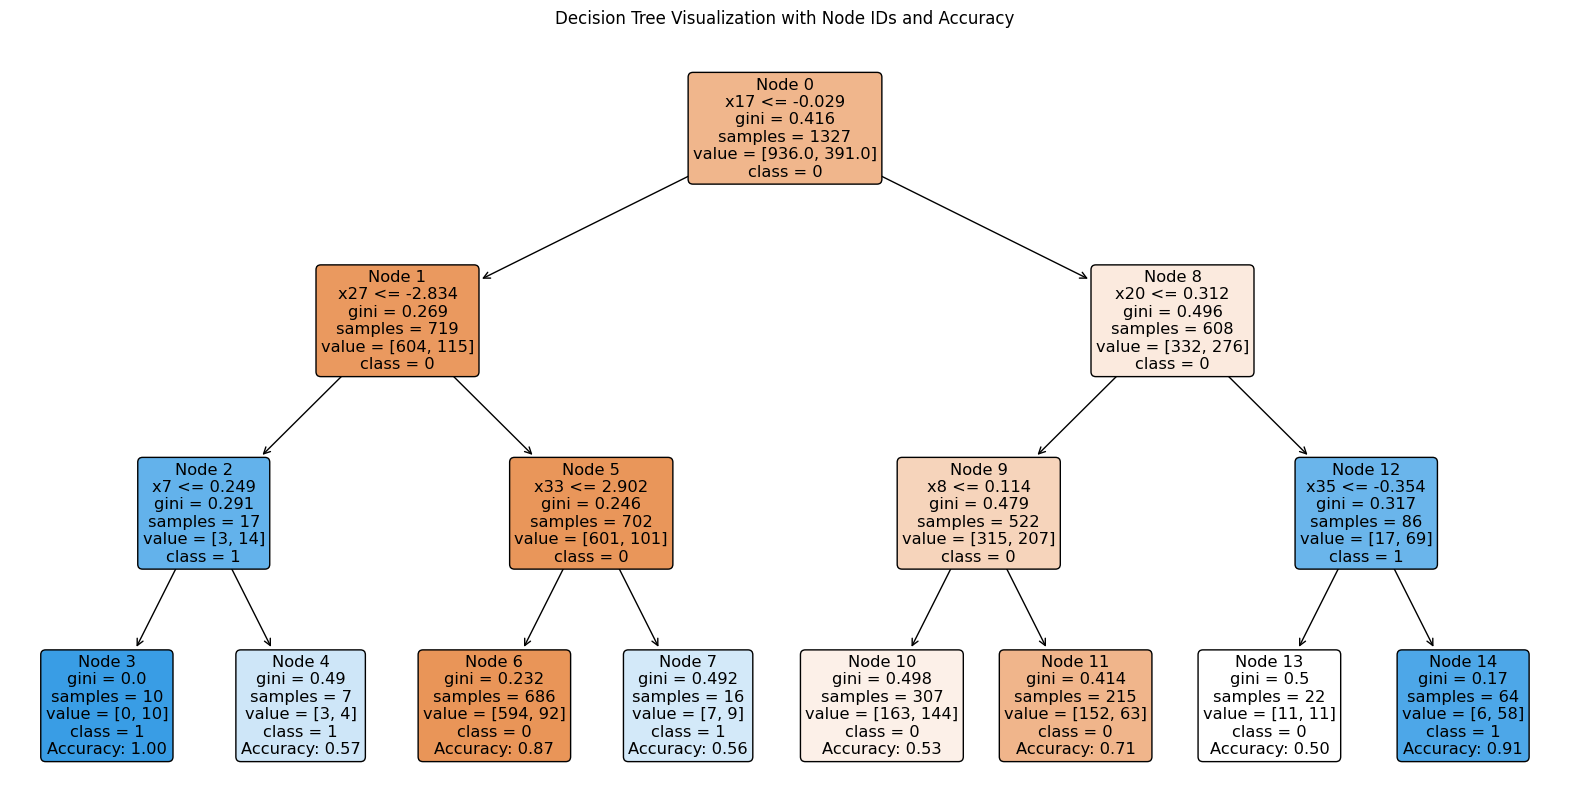

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the initial decision tree with node accuracy
print("\nInitial Decision Tree Visualization with Node Accuracy:")
num_features = X_train.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
visualize_tree_with_node_accuracy(best_model, node_accuracies, feature_names)

# --- Merging New Samples with the Original Training Set ---
print("\nMerging New Samples with the Original Training Set:")

# # Concatenate the newly generated samples with the original training set
# X_train_augmented = pd.concat([X_train, generated_samples.drop(columns=['label'])], ignore_index=True)
# y_train_augmented = pd.concat([y_train, generated_samples['label']], ignore_index=True)

# # Display the new size of the training set
# print(f"\nTraining data size after adding new samples: {X_train_augmented.shape}")
# print(f"Label size after adding new samples: {y_train_augmented.shape}")

# # Check the distribution of the labels in the augmented training set
# print("\nLabel distribution in the augmented training set:")
# print(y_train_augmented.value_counts(normalize=True))

# Perform grid search on the augmented training data
grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
print(f"Best Parameters for Retrained Model: {grid_search_augmented.best_params_}")

# Retrain the model with the best parameters from grid search
best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)

# Calculate node accuracy for the retrained model
node_accuracies_retrained = calculate_node_accuracy(best_retrained_model, X_train_augmented, y_train_augmented)

# Plot the retrained decision tree with node accuracy
print("\nVisualization of Retrained Decision Tree with Node Accuracy:")
visualize_tree_with_node_accuracy(best_retrained_model, node_accuracies_retrained, feature_names)

### Compare the Results of Initial and Augmented Models


Evaluating the Initial Model on the Test Set with Adjusted Threshold:
Evaluation Metrics at Threshold 0.29:
Accuracy: 0.66
Precision: 0.45
Recall: 0.55
F1-Score: 0.49
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       225
           1       0.45      0.55      0.49        99

    accuracy                           0.66       324
   macro avg       0.61      0.63      0.62       324
weighted avg       0.68      0.66      0.67       324



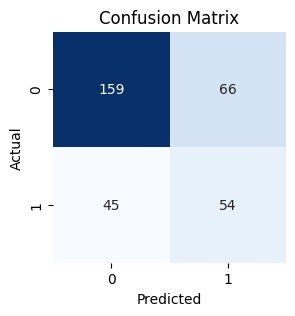


Evaluating the Retrained Model on the Test Set with Adjusted Threshold:
Evaluation Metrics at Threshold 0.29:
Accuracy: 0.63
Precision: 0.43
Recall: 0.65
F1-Score: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       225
           1       0.43      0.65      0.51        99

    accuracy                           0.63       324
   macro avg       0.61      0.63      0.61       324
weighted avg       0.69      0.63      0.64       324



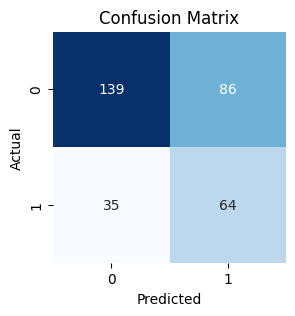

In [18]:
def evaluate_model_with_threshold(model, X_test, y_test, threshold):
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Apply the custom threshold to get class predictions
    y_pred = (y_proba >= threshold).astype(int)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Evaluation Metrics at Threshold {threshold:.2f}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# --- Initial Model Evaluation ---
print("\nEvaluating the Initial Model on the Test Set with Adjusted Threshold:")
evaluate_model_with_threshold(best_model, X_test, y_test, best_threshold)

# --- Augmented Model Evaluation ---
print("\nEvaluating the Retrained Model on the Test Set with Adjusted Threshold:")
evaluate_model_with_threshold(best_retrained_model, X_test, y_test, best_threshold)

### Passing the Test set through the Retrained Tree

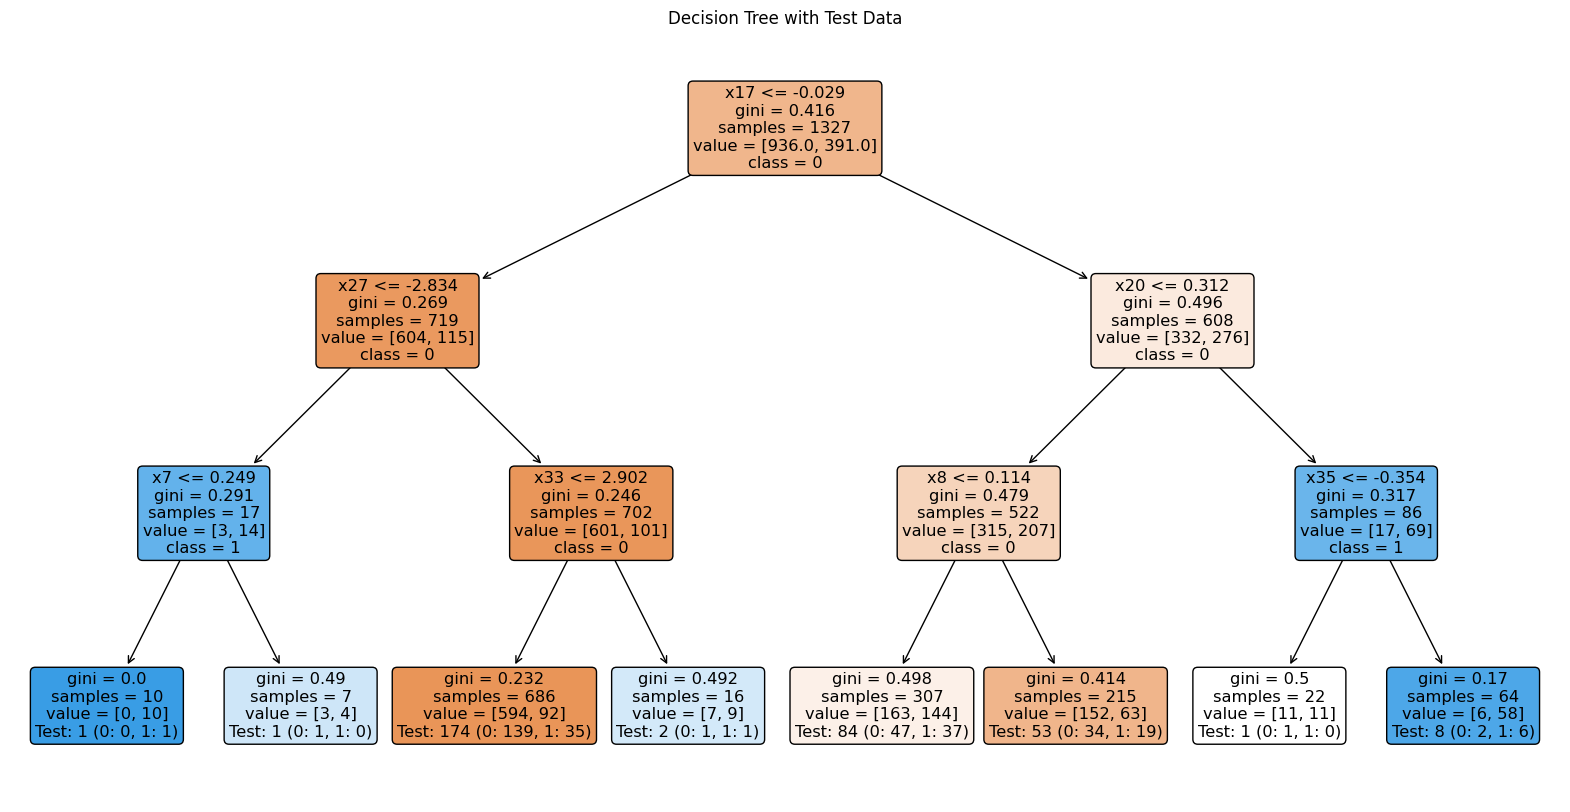

In [19]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def annotate_tree_with_test_data(tree_model, X_test, y_test, feature_names):
    # Apply the model to get the leaf nodes for each test instance
    leaf_ids = tree_model.apply(X_test)

    # Count the number of occurrences of each class in each leaf node
    leaf_counts = {}
    for leaf_id, label in zip(leaf_ids, y_test):
        if leaf_id not in leaf_counts:
            leaf_counts[leaf_id] = {'total': 0, 'class_0': 0, 'class_1': 0}
        leaf_counts[leaf_id]['total'] += 1
        if label == 0:
            leaf_counts[leaf_id]['class_0'] += 1
        else:
            leaf_counts[leaf_id]['class_1'] += 1

    # Visualize the tree
    plt.figure(figsize=(20, 10))
    tree_plot = plot_tree(tree_model, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True)

    # Modify annotations to include test data information
    for i, text in enumerate(plt.gca().texts):
        # Node id is assumed to be the i-th node
        if i in leaf_counts:
            text_parts = text.get_text().split('\n')
            text_parts[-1] = f"Test: {leaf_counts[i]['total']} (0: {leaf_counts[i]['class_0']}, 1: {leaf_counts[i]['class_1']})"
            text.set_text('\n'.join(text_parts))

    plt.title("Decision Tree with Test Data")
    plt.show()

# Assuming 'best_model' is your trained DecisionTreeClassifier
num_features = X_test.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
annotate_tree_with_test_data(best_retrained_model, X_test, y_test, feature_names)

## Data Augmentation: False Positives and False Negatives Analysis

This section explores how augmenting the training data by generating synthetic samples affects the model's performance, specifically focusing on False Negatives (FN) and False Positives (FP). We generate augmented data equivalent to 10%, 20%, 50%, and 100% of the original training data, retrain the model, and evaluate FN and FP for each case.


### FN and FP analysis for traning data


Generating 10.0% of class 1 data (35 samples)...
Accuracy: 0.66

Generating 20.0% of class 1 data (71 samples)...
Accuracy: 0.66

Generating 50.0% of class 1 data (178 samples)...
Accuracy: 0.66

Generating 100.0% of class 1 data (356 samples)...
Accuracy: 0.66


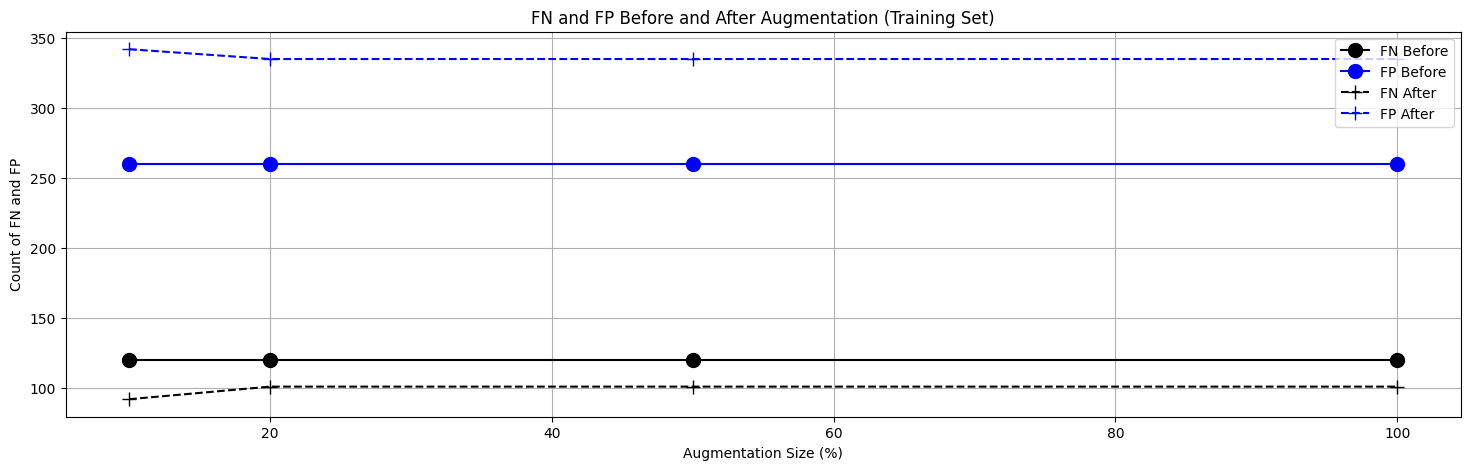

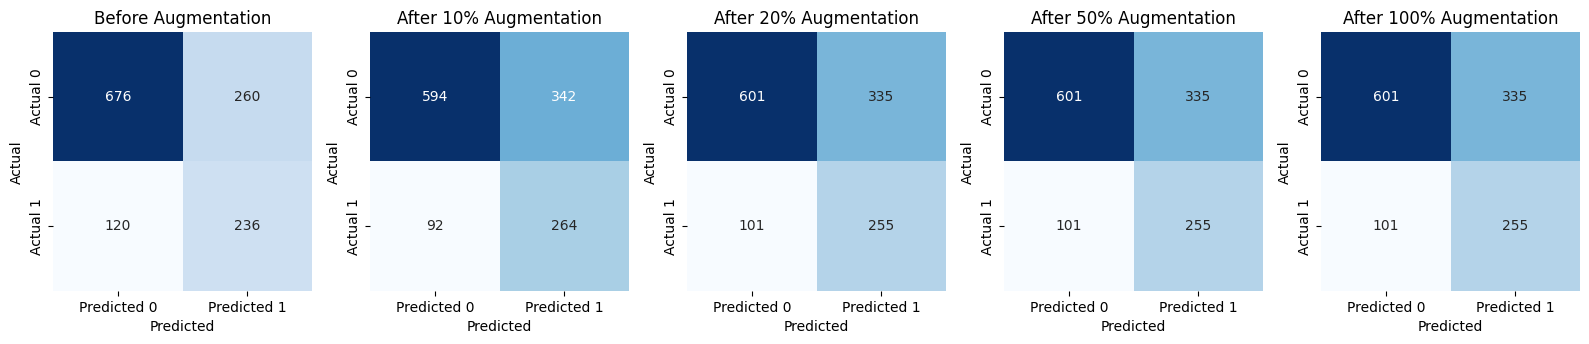

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrices side by side
def plot_confusion_matrices_side_by_side(confusion_matrices, titles, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    axes = axes.flatten()

    for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, square=True, 
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"],
                    ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Function to retrain the model and evaluate FP and FN using the best_threshold on the training set
def retrain_and_evaluate_on_train(X_train_augmented, y_train_augmented, X_train, y_train, best_threshold):
    grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
    
    best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)
    
    y_train_proba = best_retrained_model.predict_proba(X_train)[:, 1]

    y_train_pred = (y_train_proba >= best_threshold).astype(int)

    cm = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy:.2f}")
    
    return fn, fp, cm

# Function to evaluate FN and FP before augmentation on the training set
def evaluate_before_augmentation(X_train, y_train, best_model, best_threshold):
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    
    y_train_pred = (y_train_proba >= best_threshold).astype(int)
    
    cm = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return fn, fp, cm

# Function to merge generated samples with the original training data
def merge_with_training_data(X_train, y_train, generated_samples):
    X_generated = generated_samples.drop(columns=['label'])
    y_generated = generated_samples['label']

    X_train_augmented = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_augmented = pd.concat([y_train, y_generated], ignore_index=True)
    
    return X_train_augmented, y_train_augmented

# Function to augment data, retrain the model, and evaluate FN and FP for different percentages on the training set
def augment_and_evaluate_on_train(X_train, y_train, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold):
    fn_after_list = []
    fp_after_list = []
    confusion_matrices_after = []
    np.random.seed(42)  

    num_class_1_samples = len(y_train[y_train == 1])
    
    fn_before, fp_before, cm_before = evaluate_before_augmentation(X_train, y_train, best_model, best_threshold)
    
    for percentage in percentages:
        num_samples_to_generate = int(num_class_1_samples * percentage)
        print(f"\nGenerating {percentage * 100}% of class 1 data ({num_samples_to_generate} samples)...")
        
        generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples_to_generate)
        
        X_train_augmented, y_train_augmented = merge_with_training_data(X_train, y_train, generated_samples)
        
        fn_after, fp_after, cm_after = retrain_and_evaluate_on_train(X_train_augmented, y_train_augmented, X_train, y_train, best_threshold)
        fn_after_list.append(fn_after)
        fp_after_list.append(fp_after)
        confusion_matrices_after.append(cm_after)
    
    return fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after

percentages = [0.1, 0.2, 0.5, 1.0]  # Percentages of class 1 data to generate

# Evaluate for different percentages of augmentation on the training set
fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after = augment_and_evaluate_on_train(
    X_train, y_train, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold
)

# Prepare the results dataframe with the data from your experiment
results_df = pd.DataFrame({
    'FN Before': [fn_before] * len(percentages),  
    'FP Before': [fp_before] * len(percentages), 
    'FN After': fn_after_list,  
    'FP After': fp_after_list 
})

# Function to create the plot for FN and FP
def plot_fn_fp_augmentation(results_df, percentages):
    plt.figure(figsize=(18, 5))

    plt.plot([int(p * 100) for p in percentages], results_df['FN Before'], 'ko-', label='FN Before', markersize=10)

    plt.plot([int(p * 100) for p in percentages], results_df['FP Before'], 'bo-', label='FP Before', markersize=10)

    plt.plot([int(p * 100) for p in percentages], results_df['FN After'], 'k+--', label='FN After', markersize=10)

    plt.plot([int(p * 100) for p in percentages], results_df['FP After'], 'b+--', label='FP After', markersize=10)

    plt.xlabel('Augmentation Size (%)')
    plt.ylabel('Count of FN and FP')
    plt.title('FN and FP Before and After Augmentation (Training Set)')
    plt.legend(loc='upper right')

    plt.grid(True)
    plt.show()

plot_fn_fp_augmentation(results_df, percentages)

all_confusion_matrices = [cm_before] + confusion_matrices_after
titles = ['Before Augmentation'] + [f'After {int(p*100)}% Augmentation' for p in percentages]
plot_confusion_matrices_side_by_side(all_confusion_matrices, titles, nrows=1, ncols=5)

### FN and FP analysis for test data


Generating 10.0% of class 1 data (35 samples)...
Accuracy: 0.63

Generating 20.0% of class 1 data (71 samples)...
Accuracy: 0.63

Generating 50.0% of class 1 data (178 samples)...
Accuracy: 0.63

Generating 100.0% of class 1 data (356 samples)...
Accuracy: 0.63


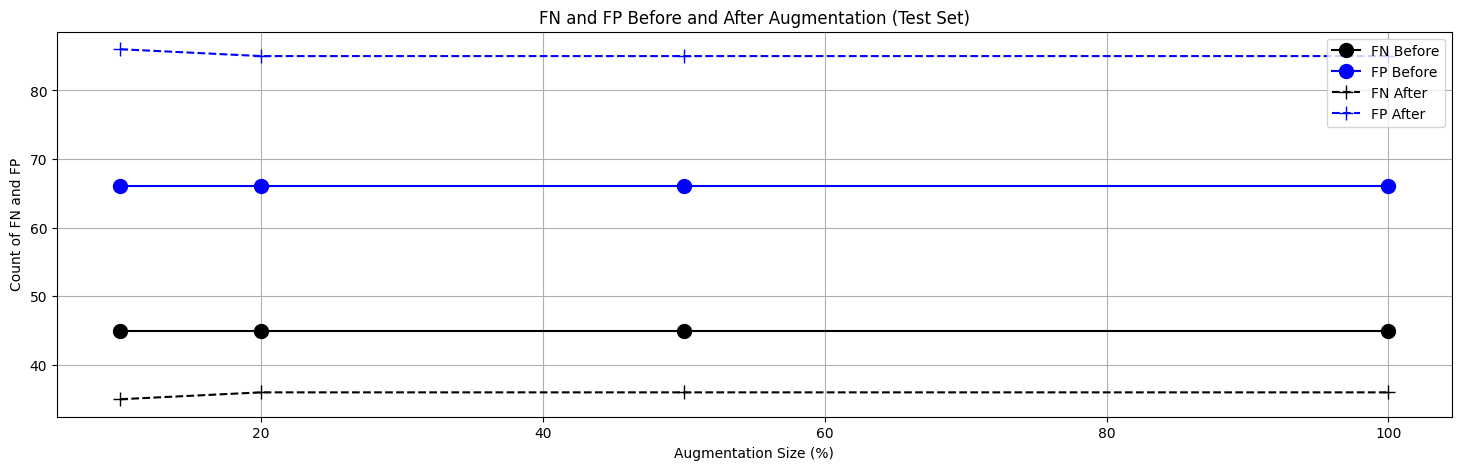

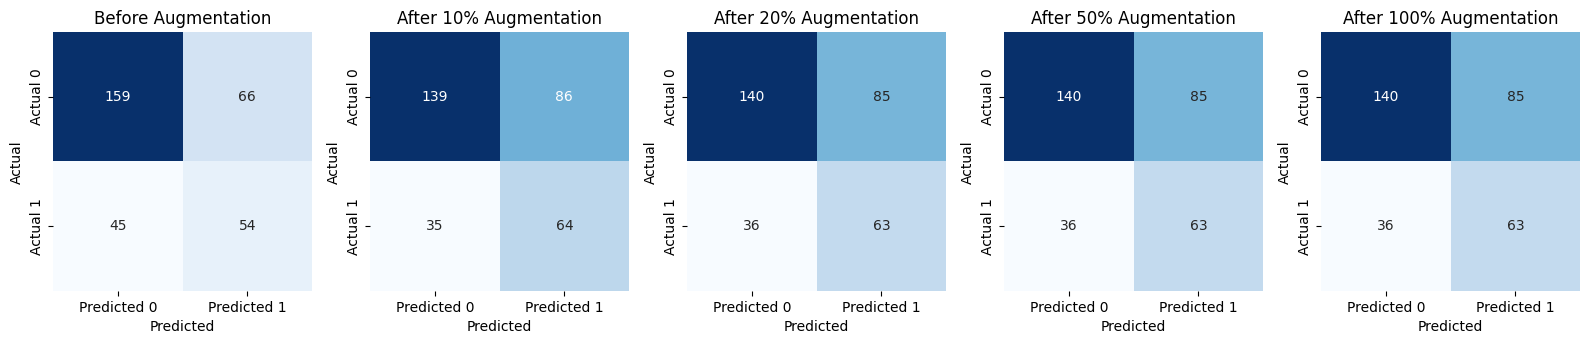

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrices side by side
def plot_confusion_matrices_side_by_side(confusion_matrices, titles, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    axes = axes.flatten()

    for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, square=True, 
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"],
                    ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Function to retrain the model and evaluate FP and FN using the best_threshold on the test set
def retrain_and_evaluate_on_test(X_train_augmented, y_train_augmented, X_test, y_test, best_threshold):
    # Perform grid search on the augmented training data
    grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
    
    # Retrain the model with the best parameters from grid search
    best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)
    
    # Get predicted probabilities on the test set
    y_test_proba = best_retrained_model.predict_proba(X_test)[:, 1]

    # Apply the best threshold
    y_test_pred = (y_test_proba >= best_threshold).astype(int)

    # Get confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy:.2f}")
    
    return fn, fp, cm

# Function to evaluate FN and FP before augmentation on the test set
def evaluate_before_augmentation(X_test, y_test, best_model, best_threshold):
    # Get predicted probabilities on the test set
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Apply the best threshold
    y_test_pred = (y_test_proba >= best_threshold).astype(int)
    
    # Get confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return fn, fp, cm

# Function to merge generated samples with the original training data
def merge_with_training_data(X_train, y_train, generated_samples):
    # Extract features and labels from the generated samples
    X_generated = generated_samples.drop(columns=['label'])
    y_generated = generated_samples['label']

    # Concatenate the original training data with the generated data
    X_train_augmented = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_augmented = pd.concat([y_train, y_generated], ignore_index=True)
    
    return X_train_augmented, y_train_augmented

# Function to augment data, retrain the model, and evaluate FN and FP for different percentages on the test set
def augment_and_evaluate_on_test(X_train, y_train, X_test, y_test, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold):
    fn_after_list = []
    fp_after_list = []
    confusion_matrices_after = []
    np.random.seed(42)  # Ensuring consistent random seed for reproducibility

    # Get the number of class 1 samples in the training set
    num_class_1_samples = len(y_train[y_train == 1])
    
    # Evaluate FN and FP before augmentation
    fn_before, fp_before, cm_before = evaluate_before_augmentation(X_test, y_test, best_model, best_threshold)
    
    for percentage in percentages:
        num_samples_to_generate = int(num_class_1_samples * percentage)
        print(f"\nGenerating {percentage * 100}% of class 1 data ({num_samples_to_generate} samples)...")
        
        # Generate augmented data
        generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples_to_generate)
        
        # Merge with training data
        X_train_augmented, y_train_augmented = merge_with_training_data(X_train, y_train, generated_samples)
        
        # Retrain and evaluate the model on the test set
        fn_after, fp_after, cm_after = retrain_and_evaluate_on_test(X_train_augmented, y_train_augmented, X_test, y_test, best_threshold)
        fn_after_list.append(fn_after)
        fp_after_list.append(fp_after)
        confusion_matrices_after.append(cm_after)
    
    return fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after

# Define percentages to evaluate
percentages = [0.1, 0.2, 0.5, 1.0]  # Percentages of class 1 data to generate

# Evaluate for different percentages of augmentation on the test set
fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after = augment_and_evaluate_on_test(
    X_train, y_train, X_test, y_test, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold
)

# Prepare the results dataframe with the data from your experiment
results_df = pd.DataFrame({
    'FN Before': [fn_before] * len(percentages),  # FN before is constant for all percentages
    'FP Before': [fp_before] * len(percentages),  # FP before is constant for all percentages
    'FN After': fn_after_list,  # FN after augmentation for each percentage
    'FP After': fp_after_list   # FP after augmentation for each percentage
})

# Function to create the plot for FN and FP
def plot_fn_fp_augmentation(results_df, percentages):
    plt.figure(figsize=(18, 5))

    # Plot FN before augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FN Before'], 'ko-', label='FN Before', markersize=10)

    # Plot FP before augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FP Before'], 'bo-', label='FP Before', markersize=10)

    # Plot FN after augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FN After'], 'k+--', label='FN After', markersize=10)

    # Plot FP after augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FP After'], 'b+--', label='FP After', markersize=10)

    # Add labels and title
    plt.xlabel('Augmentation Size (%)')
    plt.ylabel('Count of FN and FP')
    plt.title('FN and FP Before and After Augmentation (Test Set)')
    plt.legend(loc='upper right')

    # Show the plot
    plt.grid(True)
    plt.show()

# Plot FN and FP for different augmentation sizes
plot_fn_fp_augmentation(results_df, percentages)

# Plot confusion matrices: 1 before and 4 after augmentation
all_confusion_matrices = [cm_before] + confusion_matrices_after
titles = ['Before Augmentation'] + [f'After {int(p*100)}% Augmentation' for p in percentages]
plot_confusion_matrices_side_by_side(all_confusion_matrices, titles, nrows=1, ncols=5)